# Prof Josh Speagle MCMC Paper Exercises

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import optimize
from scipy import stats
import scipy

In [2]:
def N(x,mu,sigma):
    '''
    Normal distribution
    '''
    return (1/(2*np.pi*sigma**2)**(1/2))*np.e**(-1/2*(mu-x)**2/sigma**2)

## Noisy Mean

In [3]:
# Assuming gaussian model

#data
T_obs = [26.3, 30.2, 29.4, 30.1, 29.8]
n_obs = [1.7, 1.8, 1.2, 0.5, 1.3]

#prior
T_prior = 25
n_prior = 1.5
def prior(T):
    return N(T,T_prior,n_prior)

#likelihood
def likelihood(T):
    value = 1
    for i in range(0,len(T_obs)):
        value *= N(T,T_obs[i],n_obs[i])
    return value

Lpi = lambda x: prior(x)*likelihood(x)

evidence = scipy.integrate.quad(Lpi,25,35)
print(f'Evidence: {evidence[0]}')

def posterior(T):
    return Lpi(T)/evidence[0]

#print(scipy.integrate.quad(posterior,25,35)[0])

Evidence: 9.347789688149879e-07


(18.0, 32.0)

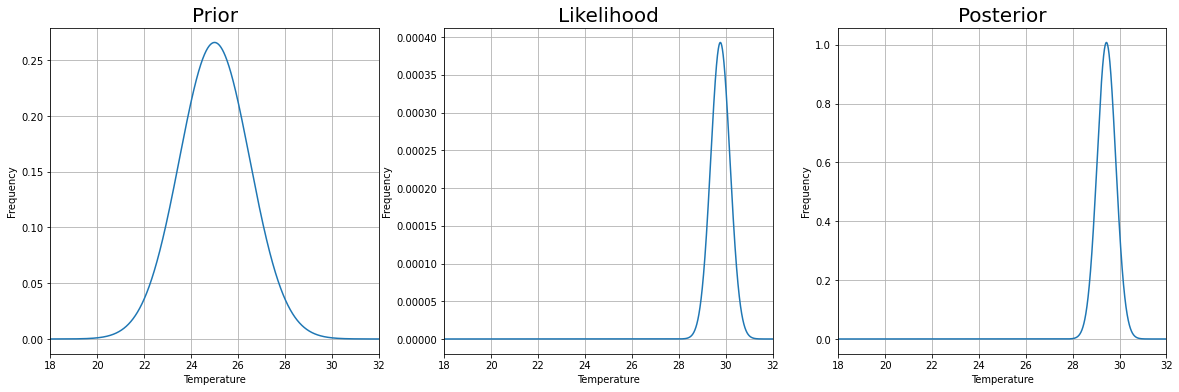

In [4]:
fig, ax = plt.subplots(1,3,figsize=(20,6))

x_range = np.arange(17,32,0.002)

ax[0].plot(x_range, prior(x_range))
ax[0].set_title('Prior',size=20)
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Temperature')
ax[0].grid()
ax[0].set_xlim(18,32)

ax[1].plot(x_range, likelihood(x_range))
ax[1].set_title('Likelihood',size=20)
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Temperature')
ax[1].grid()
ax[1].set_xlim(18,32)

ax[2].plot(x_range, posterior(x_range))
ax[2].set_title('Posterior',size=20)
ax[2].set_ylabel('Frequency')
ax[2].set_xlabel('Temperature')
ax[2].grid()
ax[2].set_xlim(18,32)

Prior seems to be off by quite a bit, so not the best assumption. Likelihood is more to the right and posterior is more in between but closer to likelihood

## Noisy Mean Revisted

### Point Estimates

In [5]:
#Mean
def mean_loss(estimate):
    mean_model = lambda x: (estimate-x)**2*posterior(x)
    return scipy.integrate.quad(mean_model,20,40)[0]
    
#Median
def median_loss(estimate):
    median_model = lambda x: np.abs(estimate-x)*posterior(x)
    return scipy.integrate.quad(median_model,20,40)[0]

#Mode
def mode_loss(estimate):
    return -1*posterior(estimate)

#Assymetrical
def assym_loss(estimate):
    assym_model = lambda x: (np.abs(estimate-x) if x >= T_prior else np.abs(estimate-x)**3)*posterior(x)
    return scipy.integrate.quad(assym_model,20,40)[0]

In [6]:
mean = optimize.minimize(mean_loss,T_prior+4,bounds=[(24,31)]).x[0]
median = optimize.minimize(median_loss,T_prior+4,bounds=[(24,31)]).x[0]
mode = optimize.minimize(mode_loss,T_prior+4,bounds=[(24,31)]).x[0]
assym = optimize.minimize(assym_loss,T_prior+4,bounds=[(24,31)]).x[0]

print(f'Mean: {mean}\nMedian: {median}\nMode: {mode}\nAssymetrical: {assym}')

Mean: 29.439995194671305
Median: 29.439992751078492
Mode: 29.43999520415357
Assymetrical: 29.439992751078492


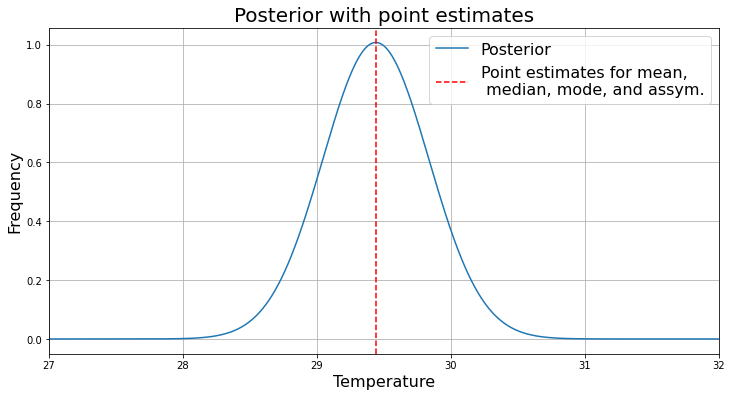

In [7]:
plt.figure(figsize=(12,6))

plt.plot(x_range, posterior(x_range),label='Posterior')
plt.title('Posterior with point estimates',size=20)
plt.ylabel('Frequency',size=16)
plt.xlabel('Temperature',size=16)
plt.grid()
plt.xlim(27,32)
plt.axvline(mean,ls='--',color='r',label='Point estimates for mean,\n median, mode, and assym.')
plt.legend(fontsize=16)

In theory mean, median, and mode should be the same since a Gaussian is symmetric with the maximum at the mean.

Assymetrical seems to be the same as the others since the distirbution is almost entirely above T_prior anyway.

These behaviours are reflected in our results.

### Credible Intervals

#### Posterior Threshold

In [61]:
def p_area(bounds):
    return scipy.integrate.quad(posterior,bounds[0],bounds[1])[0]

def p_threshold_bounds(threshold):
    bounds = []
    for i in x_range:
        if posterior(i-0.002) < threshold and posterior(i) >= threshold:
            bounds.append(i)
        if posterior(i-0.002) >= threshold and posterior(i) < threshold:
            bounds.append(i)
    return p_area(bounds)

def threshold_50(threshold):
    return np.abs(p_threshold_bounds(threshold)-0.5)

def threshold_80(threshold):
    return np.abs(p_threshold_bounds(threshold)-0.8)

def threshold_95(threshold):
    return np.abs(p_threshold_bounds(threshold)-0.95)

In [59]:
P_50 = optimize.minimize(threshold_50,0.8,bounds=[(0,1)],method='Nelder-Mead').x[0]
P_80 = optimize.minimize(threshold_80,0.4,bounds=[(0,1)],method='Nelder-Mead').x[0]
P_95 = optimize.minimize(threshold_95,0.2,bounds=[(0,1)],method='Nelder-Mead').x[0]

In [65]:
print(f'50% threshold: {P_50}')
print(f'80% threshold: {P_80}')
print(f'95% threshold: {P_95}')

def p_bounds(threshold):
    bounds = []
    for i in x_range:
        if posterior(i-0.002) < threshold and posterior(i) >= threshold:
            bounds.append(i)
        if posterior(i-0.002) >= threshold and posterior(i) < threshold:
            bounds.append(i)
    return bounds


print(f'50% interval: {p_bounds(P_50)}')
print(f'80% interval: {p_bounds(P_80)}')
print(f'95% interval: {p_bounds(P_95)}')

50% threshold: 0.8025
80% threshold: 0.44500000000000006
95% threshold: 0.14750000000000013
50% interval: [29.173999999993253, 29.707999999992957]
80% interval: [28.933999999993386, 29.947999999992824]
95% interval: [28.665999999993534, 30.215999999992675]


#### Percentile

In [9]:
#Fitting to a gaussian
ppov, pcov = optimize.curve_fit(N,x_range,posterior(x_range),p0=[mean,0.5])

P_mean, P_std = ppov[0], ppov[1]

#50% interval
upper_50 = P_mean + stats.norm.ppf(0.75)*P_std
lower_50 = P_mean - stats.norm.ppf(0.75)*P_std

#80% interval
upper_80 = P_mean + stats.norm.ppf(0.9)*P_std
lower_80 = P_mean - stats.norm.ppf(0.9)*P_std

#95% interval
upper_95 = P_mean + stats.norm.ppf(0.975)*P_std
lower_95 = P_mean - stats.norm.ppf(0.975)*P_std


print(f'50% interval: [{lower_50:.4f},{upper_50:.4f}]')
print(f'80% interval: [{lower_80:.4f},{upper_80:.4f}]')
print(f'95% interval: [{lower_95:.4f},{upper_95:.4f}]')

50% interval: [29.1731,29.7069]
80% interval: [28.9328,29.9472]
95% interval: [28.6644,30.2156]


They appear to give the same results. This is liekly because a Gaussian is symmetric, so the bounds are equidistance from the max.

Some of the slight difference between the two is because the threshold method used has a kind of set reslution.

### Posterior Predictive

We will try the points where $(T_6,\sigma_6)$ equal $(29,0)$, $(33,0.5)$, or $(31,2)$.

In [79]:
#(29,0)
#delta function? or impossible maybe?

#(33,0.5)
PP2_f = lambda x: posterior(x)*N(x,33,0.5)
PP2 = scipy.integrate.quad(PP2_f,25,40)

#(31,2)
PP3_f = lambda x: posterior(x)*N(x,31,2)
PP3 = scipy.integrate.quad(PP3_f,25,40)

print(f'Posterior Predictive for (29,0): Not possible, or maybe I don\'t know how to do.')
print(f'Posterior Predictive for (33,0.5): {PP2[0]:.4e}.')
print(f'Posterior Predictive for (31,2): {PP3[0]:.4e}.')

Posterior Predictive for (29,0): Not possible, or maybe I don't know how to do.
Posterior Predictive for (33,0.5): 1.0668e-07.
Posterior Predictive for (31,2): 1.4602e-01.


### Model Comparison

In [70]:
# Assuming gaussian model

#prior2
T_prior2 = 30
n_prior2 = 3
def prior2(T):
    return N(T,T_prior2,n_prior2)

#evidence
Lpi2 = lambda x: prior2(x)*likelihood(x)
evidence2 = scipy.integrate.quad(Lpi2,25,40)
print(f'Evidence 2: {evidence2[0]:.4f}')

print(f'Bayes factor R^1_2 = {evidence[0]/evidence2[0]:.4f}')

Evidence 2: 0.0001
Bayes factor R^1_2 = 0.0176


This result is assuming $\pi_1=\pi_2$.

Model 2 with the higher mean temperature is favoured.